In [667]:
#### %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline
from __future__ import division

import numpy as np
import pandas as pd
import random
from random import randint

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


In [522]:
def textPlot(ax, fs, font):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(fs)
    return ax

## 1. Define Levy Flight Distribution

In [352]:
def levy(r0, a, k, r):
    return exp(-r/k)*(r + r0)**(-a)

In [424]:
r0 = 100  ## Distance between cells
a = 2
k = 1500

## 2. Define grid Size

In [425]:
gs = 20 ## Cells per side
S = gs*gs ## Grid Size
nc = 100 ## Number of habitants per cells
N = nc*S

### 2.1 Compute the distance between all the cells

In [427]:
d = []
I = []
J = []
c = []
X = []
Y = []
count = 0
for i in range(0, S):
    for j in range(0, S):
        if i == j: continue
        x1,x2 = i%gs, j%gs
        y1,y2 = i//gs, j//gs
        dist = sqrt( float(x1-x2)**2 + float(y1-y2)**2)  # pythagoras theorem
        #dist = abs(x1-x2) + abs(y1-y2)
        dist *= r0
        d.append(dist)
        I.append(i)
        J.append(j)  

In [ ]:
r = 1
p = []  ## probability
R = []  ## distance
for i in range(0,60000):
    R.append(r)
    p.append(levy(r0, a, k, r)*10000)
    r+=.01
dr = np.array(R)
dp = np.array(p)

Text(0, 0.5, 'Probability $P(r)$')

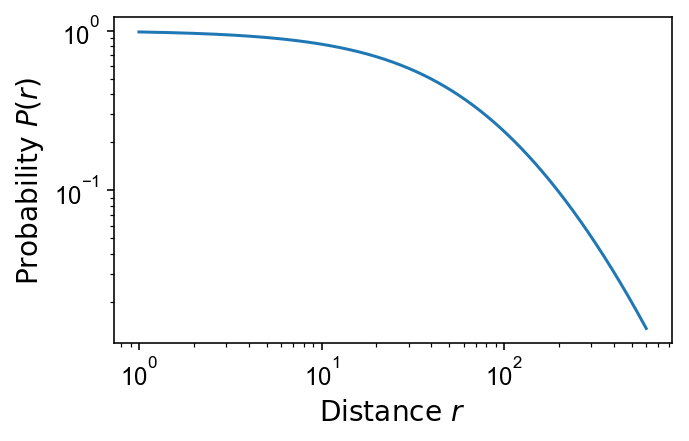

In [523]:
fig,ax = plt.subplots(figsize=(5,3))
ax = textPlot(ax, 12, 'Arial')
plt.plot(R,p)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance '+r'$r$', size = 14)
ax.set_ylabel('Probability '+r'$P(r)$', size = 14)

In [430]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

### 2.2 Assign home work cells according to the Levy distribution

In [432]:
nagents = np.arange(0,N)
cell = 0
hc = []
wc = []
upd = nc
same = int(0.2*nc)
MR = np.zeros((gs, gs))
for i in range(0, S):  ### For all the cell
    for j in range(0,nc): ## For each agent in the cell
        hc.append(cell)
        if j < same:  ## First 20 assign same home/work cell
            wc.append(cell)
        else:
            rand = random.uniform(0, 1)
            fd = find_nearest(dp, rand)
            wx = np.where(dp==fd)
            dx = R[wx[0][0]]
            tmp = df[df['i']==cell]
            ft = find_nearest(tmp['d'], dx)
            tmp = tmp[tmp['d']==ft]
            k = randint(0,len(tmp)-1)
            idx = tmp.index[k]
            wc.append(tmp['j'][idx])
    cell+=1

### 2.3 Save home work locations network

In [433]:
net = pd.DataFrame()
net['home']=hc
net['work']=wc
net.to_csv('Code/networkSimulations/realNetwork.dat', sep=' ', header=None, index=None)

## 3 Define initial mosquito

In [489]:
AV = [] ## adult
AM = [] ## aquatic
C = []
for i in range(0, S):
    AV.append(randint(0,10))
    AM.append(randint(0,100))
    C.append(i)

### 3.1 Save initial mosquitos

In [490]:
adult = pd.DataFrame()
adult['cell']=C
adult['m']=AV
adult.to_csv('Code/Initial/adult.dat',  sep=' ', header=None, index=None)

aquatic = pd.DataFrame()
aquatic['cell']=C
aquatic['m']=AM
aquatic.to_csv('Code/Initial/aquatic.dat',  sep=' ', header=None, index=None)

## 4 Analyze results

In [529]:
xv = 0.1  ## maximum number of mosquito per humans
br = 0.2  ## bite rate
pathRes = "Code/results/"
stat = np.arange(0,10)  ## number of runs of each simulations (for statistics)
fileName = []
for i in stat:
    fileName.append("run_%d_%f_%f.csv"%(i, xv, br)) 

### 4.1 Read results and average

#### 4.1.1 Temporal Analysis

In [608]:
infH = []  ## infected humans
for i in fileName:
    tmp = pd.read_csv(pathRes+i, sep=' ') ## read the file
    k = tmp.groupby('Time').sum()  ## Sum of the compartments for each cell at each time
    infH.append(k['I'])
ih = np.percentile(infH, [2.5,50,97.5], axis=0)  ## compute the percentile

Text(0, 0.5, 'Infected $I(t)$')

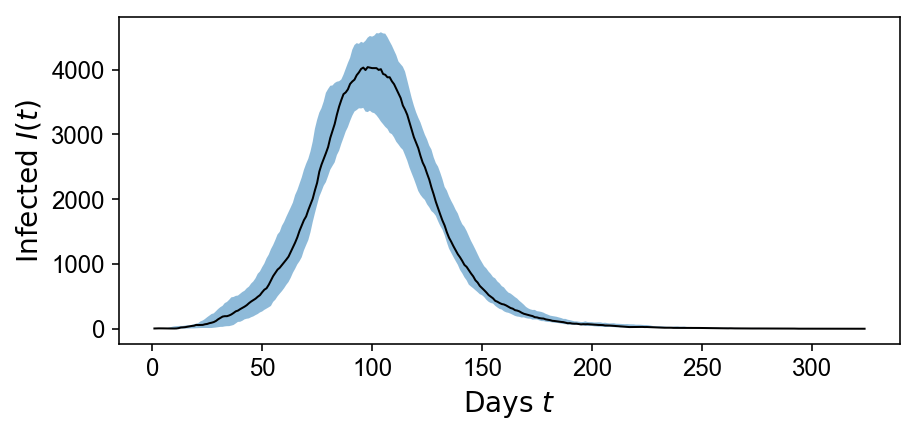

In [609]:
fig,ax = plt.subplots(figsize=(7,3))
ax = textPlot(ax, 12, 'Arial')
plt.plot(k.index,ih[1], color='black', lw=1)
ax.fill_between(k.index, ih[0], ih[2], alpha=0.5)
ax.set_xlabel('Days '+r'$t$', size = 14)
ax.set_ylabel('Infected '+r'$I(t)$', size = 14)

#### 4.1.2 Spatial Diffusion: Recovered Individuals


In [624]:
infH = []  ## infected humans
M = []
for i in range(0, 363):
    M.append(np.zeros((gs,gs)))

for i in fileName:
    df = pd.read_csv(pathRes+i, sep=' ') ## read the file
    count = 0
    for t in range(1, 364):
        tmp = df[df['Time']==t]
        k = tmp.groupby('Node').sum()
        for j in k.index:
            x = j%gs
            y = j//gs
            M[t-1][x,y]+=k['R'][j]

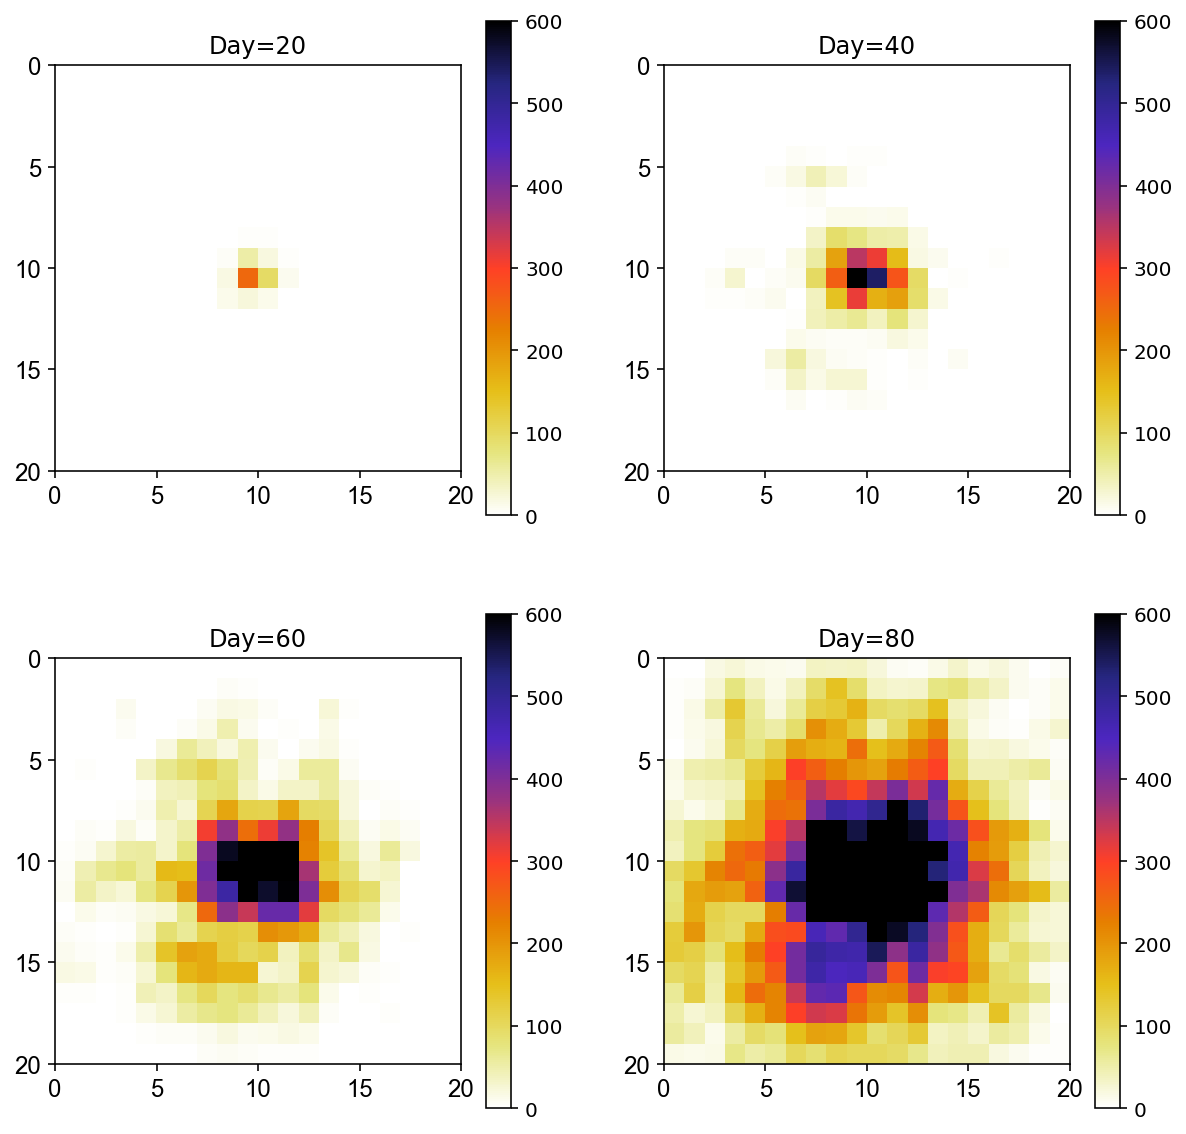

In [688]:
days = [20,40,60,80]
fig, ax = plt.subplots(2, 2, figsize=(10,10))
d = 0
for i in range(0,2):
    for j in range(0,2):
        t = days[d]
        ax1 = ax[i][j]
        ax1 = textPlot(ax1, 12, 'Arial')
        im = ax1.imshow(M[t], cmap='CMRmap_r',vmin=0, vmax=600)
        ax1.set_title('Day=%d'%t)
        ax1.set_xticks([-0.5,4.5,9.5,14.5,19.5])
        ax1.set_xticklabels([0,5,10,15,20])
        ax1.set_yticks([-0.5,4.5,9.5,14.5,19.5])
        ax1.set_yticklabels([0,5,10,15,20])
        plt.colorbar(im,ax=ax1)
        d+=1